<a href="https://colab.research.google.com/github/Mechanics-Mechatronics-and-Robotics/Physics-based-loss-and-machine-learning-approach-in-application-to-non-Newtonian-fluids-flow-modelin/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 6.8 MB/s 
     |████████████████████████████████| 189 kB 47.0 MB/s 
     |████████████████████████████████| 1.2 MB 41.4 MB/s 
     |████████████████████████████████| 46 kB 3.1 MB/s 
     |████████████████████████████████| 56 kB 4.8 MB/s 
     |████████████████████████████████| 51 kB 313 kB/s 
Mounted at /content/gdrive


In [2]:
from fastai.vision.all import *
import cv2
from google.colab.patches import cv2_imshow


**Initialization**

The flow domain *LxL* is under study.

In [15]:
L=0.1 # L x L flow domain
imgSize = 224 # imgSize x imgSize pixels image
x1 = np.linspace(0,L,imgSize)
x2 = np.linspace(0,L,imgSize)
#scaleFactor = 1e+4 # 1e+4 pixels per 1m when resolution is 128x128 


Resize image

Path

In [4]:
 path =  Path('/content/gdrive/MyDrive/study/Publications/2022/IEEE-CEC-2022/physical-loss')
 imgPath = path/'ToyDataset'
 imgList = imgPath.ls()
 imgPath.ls()

(#3) [Path('/content/gdrive/MyDrive/study/Publications/2022/IEEE-CEC-2022/physical-loss/ToyDataset/Parallel plates and ball.png'),Path('/content/gdrive/MyDrive/study/Publications/2022/IEEE-CEC-2022/physical-loss/ToyDataset/Parallel plates with notch.png'),Path('/content/gdrive/MyDrive/study/Publications/2022/IEEE-CEC-2022/physical-loss/ToyDataset/Parallel plates.png')]

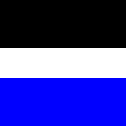

In [11]:
imgTest = Image.open(imgList[2]) 
imgTest


In [8]:
tensor(imgTest).shape

torch.Size([126, 126, 4])